In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.settings import Config
from src.utils import Network, Results #,DataProcessor
from src.models import SpatialAggregation, TemporalAggregation
from src.visualization import Visualizer
from Full_GTEP_Solve.modules_v2 import read_data, GTEP

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

In [7]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from typing import Any
from functools import lru_cache
from dataclasses import asdict
import hashlib
import json
from numba import njit, prange
from datetime import datetime

from sklearn.neighbors import NearestNeighbors

In [217]:
config = Config(
    year=2013,
    cf_k_neighbors=1,
    demand_decay_alpha=0.4,
    granularity="high_bis",
    active_features=['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'intra_correlation']
)

# # Display configuration help.
# config.help()

In [5]:
class DataProcessor:
    """
    A unified data processor that automatically selects the correct underlying processor
    based on config.granularity ("low" or "high"). It then either loads processed
    data (if it exists) or processes raw data and saves it.
    
    Usage:
      cfg = Config(**kwargs)
      processor = DataProcessor(cfg)
      data = processor.process()
    """
    def __init__(self, config: Config):
        self.config = config
        self.config_dict = asdict(self.config.data_preproc)
        self.config_dict.pop('active_features', None)
        self._processed_data: dict[str, pd.DataFrame | dict[str, pd.DataFrame]] | None = None
        if self.config.data_preproc.granularity == "high":
            self._processor = HighResDataProcessor(config)
        elif self.config.data_preproc.granularity == "low":
            self._processor = LowResDataProcessor(config)
        elif self.config.data_preproc.granularity == "high_bis":
            self._processor = HighResDataProcessorBis(config)

    def save_data(self, data: dict[str, pd.DataFrame | dict[str, pd.DataFrame]], version_suffix: str = ""):
        """
        Save processed data with versioning and static data separation. 
        Input is a dictionary with keys 'nodes', 'branches', and 'time_series'.
        The 'time_series' value is a dictionary with keys for each time series type.
        """

        version_hash = hashlib.md5(json.dumps(self.config_dict, sort_keys=True).encode()).hexdigest()[:8]
        
        base_path = Path(self.config.path.processed)
        
        # Save static data once
        base_path.mkdir(parents=True, exist_ok=True)
        if not (base_path / 'nodes.parquet').exists():
            data['nodes'].to_parquet(base_path / 'nodes.parquet')
        if not (base_path / 'branches.parquet').exists():
            data['branches'].to_parquet(base_path / 'branches.parquet')
            
        # Save versioned data
        version_path = base_path / f'v{version_hash}{version_suffix}'
        version_path.mkdir(exist_ok=True)
        
        for name, df in data['time_series'].items():
            df.to_parquet(
                version_path / f'{name}.parquet',
                index=False,
                compression='snappy'
            )

        metadata = {
            'created': datetime.now().isoformat(),
            'config_dict': self.config_dict
        }
        with open(version_path / 'metadata.json', 'w') as f:
            json.dump(metadata, f)
        
        print(f"Processed data saved to {version_path}")
    
    def load_processed_data(self, version_hash: str | None = None) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """
        Load processed data. If version_hash is not provided, compute it from the config.
        """
        base_path = Path(self.config.path.processed)

        if version_hash is None:
            version_hash = hashlib.md5(json.dumps(self.config_dict, sort_keys=True).encode()).hexdigest()[:8]

        data = {}
        data['nodes'] = pd.read_parquet(base_path / 'nodes.parquet')
        data['branches'] = pd.read_parquet(base_path / 'branches.parquet')

        version_path = base_path / f"v{version_hash}"
        data['time_series'] = {
            'wind': pd.read_parquet(version_path / "wind.parquet"),
            'solar': pd.read_parquet(version_path / "solar.parquet"),
            'demand': pd.read_parquet(version_path / "demand.parquet")
        }

        print(f"Cached processed data loaded from {version_path}")
        return data
    
    @property
    def processed_data(self) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """Lazy-loaded processed data"""
        if self._processed_data is None:
            # try:
            #     self._processed_data = self.load_processed_data()
            # except FileNotFoundError:
            self._processed_data = self._processor.process()
            # self.save_data(self._processed_data)
        return self._processed_data

In [15]:
wind, solar, demand_df, demand_points_df, population_df = load_data(config)

In [19]:
solar.shape

(8760, 385)

In [181]:
def process_capacity_factors(wind, solar) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Process capacity factors for wind and solar"""
        wind_points = np.column_stack((wind.lat.values, wind.lon.values))
        wind_values = wind.values.astype(np.float64)
        solar_points = np.column_stack((solar.lat.values, solar.lon.values))
        solar_values = solar.values.astype(np.float64)

        wind_values = np.delete(wind_values, 181, axis=1) # Remove the 181st column for wind data
        wind_points = np.delete(wind_points, 181, axis=0)  # Remove the 181st row for wind data

        wind_df = pd.DataFrame(wind_values, columns=range(wind_values.shape[1]))
        solar_df = pd.DataFrame(solar_values, columns=range(solar_values.shape[1]))

        if not np.array_equal(wind_points, solar_points):
            raise ValueError("Wind and solar points do not match!")
        
        nodes_df = pd.DataFrame(wind_points, columns=["Lat", "Lon"])
            
        return nodes_df, wind_df, solar_df

nodes_df, wind_df, solar_df = process_capacity_factors(wind, solar)
wind, solar, demand_df, demand_points_df, population_df = load_data(config)

In [51]:
wind, solar, demand_df, demand_points_df, population_df = load_data(config)


# Step 1: Assign population to grid nodes
pop_coords = population_df[['Lat', 'Lon']].values
grid_coords = nodes_df[['Lat', 'Lon']].values

nbrs = NearestNeighbors(n_neighbors=1).fit(grid_coords)
_, grid_indices = nbrs.kneighbors(pop_coords)

population_df['grid_node'] = grid_indices.flatten()
grid_population = population_df.groupby('grid_node')['population'].sum().reindex(range(len(nodes_df)), fill_value=0)
nodes_df['population'] = grid_population.values



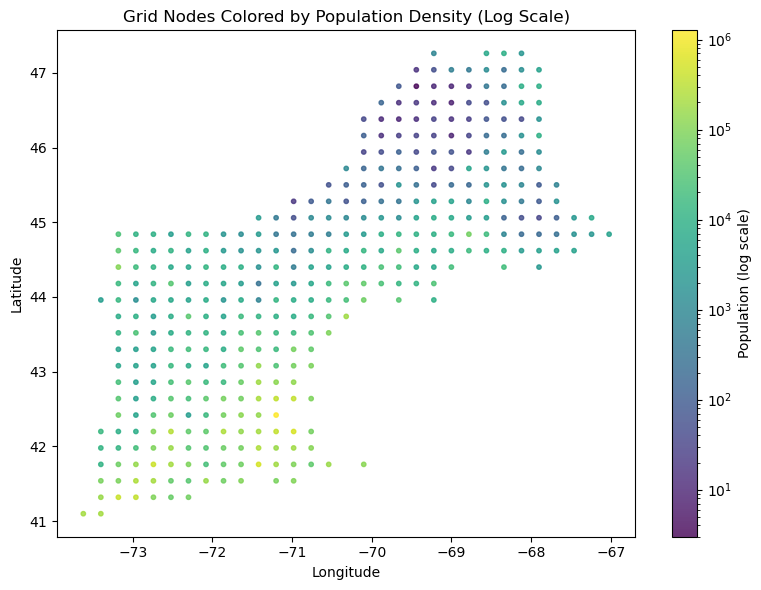

In [42]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    nodes_df["Lon"], 
    nodes_df["Lat"], 
    c=nodes_df["population"], 
    cmap="viridis", 
    s=10, 
    alpha=0.8,
    norm=LogNorm()  # Use log scale for color
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid Nodes Colored by Population Density (Log Scale)")
plt.colorbar(scatter, label="Population (log scale)")
plt.tight_layout()
plt.show()

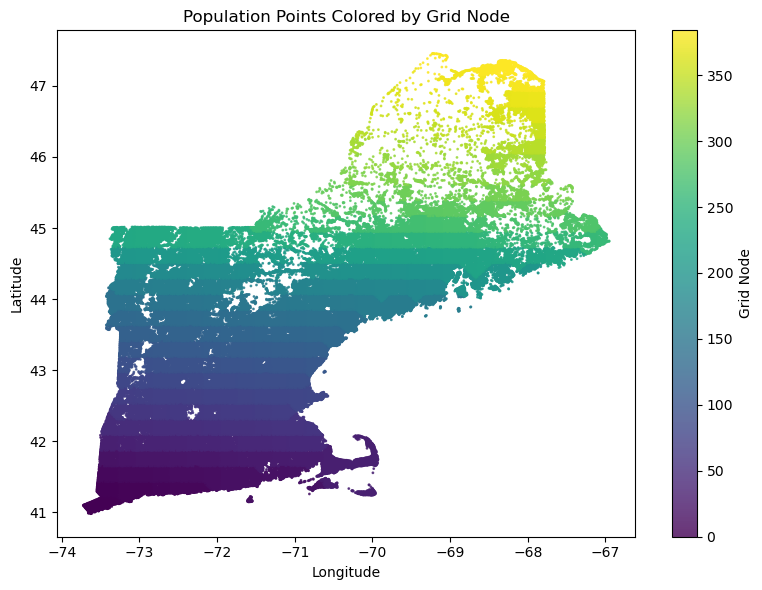

In [41]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    population_df["Lon"], 
    population_df["Lat"], 
    c=population_df["grid_node"], 
    cmap="viridis", 
    s=1,           # smaller dots
    alpha=0.8
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Population Points Colored by Grid Node")
plt.colorbar(scatter, label="Grid Node")
plt.tight_layout()
plt.savefig("population_points_colored_by_grid_node.png", dpi=300)
plt.show()

In [73]:
# Get unique original_node values in sorted order
unique_original_nodes = np.sort(np.unique(nodes_df["original_node"].values))
unique_original_nodes

(64,)

In [160]:
import os
import geopandas as gpd

state_shp = PROJECT_ROOT / "DATA" / "raw"/ "ne_population"/ "cb_2021_us_state_500k" / "cb_2021_us_state_500k.shp"

# 2) Load the U.S. state boundaries shapefile
states_gdf = gpd.read_file(state_shp)

# 3) Filter to New England states
ne_abbr = ["CT", "ME", "MA", "NH", "RI", "VT"]
ne_states = states_gdf[states_gdf["STUSPS"].isin(ne_abbr)]

# 6) Create exact mask and clip
ne_mask = ne_states.geometry.union_all()
ne_states = ne_states.to_crs(epsg=4326)

DataSourceError: c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\DATA\raw\ne_population\cb_2021_us_state_500k\cb_2021_us_state_500k.shp: No such file or directory

In [172]:
county_shp = PROJECT_ROOT / "DATA" / "raw" / "ne_population" / "cb_2021_us_county_500k" / "cb_2021_us_county_500k.shp"
counties = gpd.read_file(county_shp).to_crs(epsg=4326)
# filter by STATEFP for CT(09), ME(23), MA(25), NH(33), RI(44), VT(50)
ne_statefps = ["09","23","25","33","44","50"]
counties = counties[counties["STATEFP"].isin(ne_statefps)].copy()
# ensure unique county ID in 'GEOID'
counties["county_id"] = counties["GEOID"]  # e.g. "09001"

# 2) Build a GeoDataFrame for your grid nodes
nodes_gdf = gpd.GeoDataFrame(
    nodes_df,
    geometry=gpd.points_from_xy(nodes_df.Lon, nodes_df.Lat),
    crs="EPSG:4326",
)

# 3) Spatial‐join each node to its county
nodes_gdf = gpd.sjoin(
    nodes_gdf,
    counties[["county_id","geometry"]],
    how="left",
    predicate="within",
)

In [173]:
nodes_gdf

,Lat,Lon,geometry,index_right,county_id
0,41.10,-73.62,POINT (-73.62 41.1),306,09001
1,41.10,-73.40,POINT (-73.4 41.1),306,09001
2,41.32,-73.40,POINT (-73.4 41.32),306,09001
3,41.32,-73.18,POINT (-73.18 41.32),306,09001
4,41.32,-72.96,POINT (-72.96 41.32),935,09009
...,...,...,...,...,...
380,47.04,-67.90,POINT (-67.9 47.04),548,23003
381,47.26,-69.22,POINT (-69.22 47.26),548,23003
382,47.26,-68.56,POINT (-68.56 47.26),548,23003
383,47.26,-68.34,POINT (-68.34 47.26),548,23003


In [194]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 1) Load your data (you already have these from load_data)
#    • demand_df        : hours × counties (indexed by county FIPS as strings)
#    • population_df    : rows of (population, Lat, Lon)
#    • nodes_df         : rows of (Lat, Lon) for your 400 grid nodes
# ───────────────────────────────────────────────────────────────────────────────

# 2) Read New England county polygons
COUNTY_SHP =  PROJECT_ROOT / "DATA" / "raw" / "ne_population" / "cb_2021_us_county_500k" / "cb_2021_us_county_500k.shp"
counties = gpd.read_file(COUNTY_SHP)
ne_fips = ["09","23","25","33","44","50"]  # CT, ME, MA, NH, RI, VT
counties = counties[counties["STATEFP"].isin(ne_fips)]
counties["county_id"] = counties["GEOID"]  # e.g. "25027"
counties_proj = counties.to_crs(epsg=32619)
centroids = counties.geometry.centroid
centroids_wgs84 = centroids.to_crs("EPSG:4326")
counties = counties.to_crs(epsg=4326)

# 3) Attach each population hexagon to a county
pop_gdf = gpd.GeoDataFrame(
    population_df,
    geometry=gpd.points_from_xy(population_df.Lon, population_df.Lat),
    crs="EPSG:4326"
)
# spatial join on “within”
pop_gdf = gpd.sjoin(pop_gdf, counties[["county_id","geometry"]],
                    how="left", predicate="within")

# for any population point that fell outside (NaN county_id), snap to the nearest county
missing_pt = pop_gdf["county_id"].isna()
if missing_pt.any():
    # build centroids and kd‑tree of county centroids
    cents = np.vstack([
        centroids_wgs84.y,
        centroids_wgs84.x
    ]).T
    nbr = NearestNeighbors(n_neighbors=1).fit(cents)
    pts = np.vstack([pop_gdf.loc[missing_pt,"Lat"], pop_gdf.loc[missing_pt,"Lon"]]).T
    _, idx = nbr.kneighbors(pts)
    pop_gdf.loc[missing_pt,"county_id"] = counties.iloc[idx.flatten()]["county_id"].values

C:\Users\g630d\AppData\Local\Temp\ipykernel_5320\3251479160.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = counties.geometry.centroid


C:\Users\g630d\AppData\Local\Temp\ipykernel_5320\3606349311.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.y,
C:\Users\g630d\AppData\Local\Temp\ipykernel_5320\3606349311.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.x


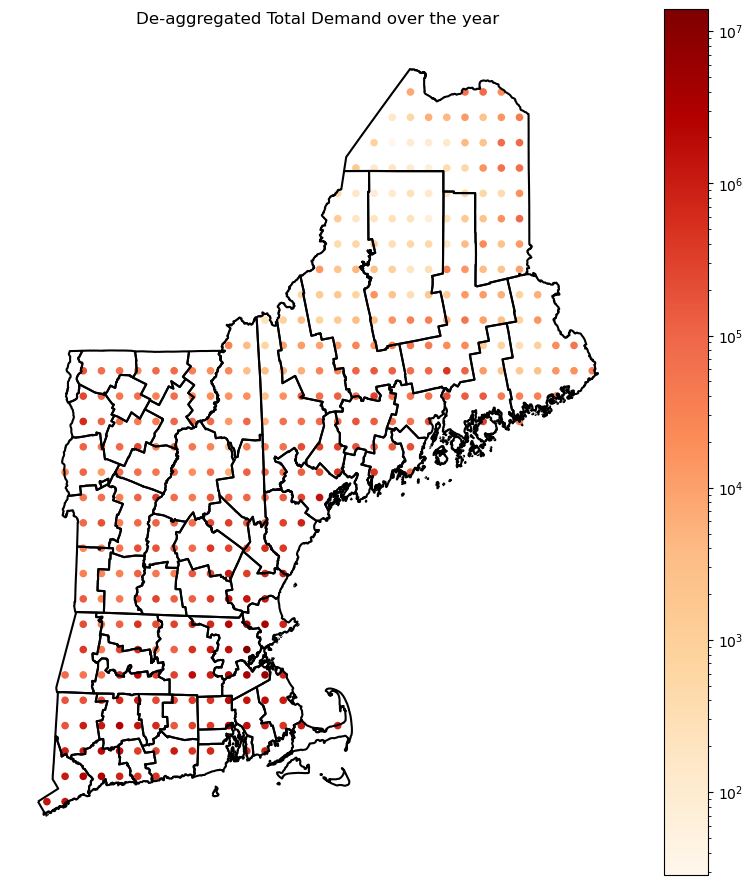

In [215]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────────────────────
# 1) Load your data (you already have these from load_data)
#    • demand_df        : hours × counties (indexed by county FIPS as strings)
#    • population_df    : rows of (population, Lat, Lon)
#    • nodes_df         : rows of (Lat, Lon) for your 400 grid nodes
# ───────────────────────────────────────────────────────────────────────────────

# 2) Read New England county polygons
COUNTY_SHP =  PROJECT_ROOT / "DATA" / "raw" / "ne_population" / "cb_2021_us_county_500k" / "cb_2021_us_county_500k.shp"
counties = gpd.read_file(COUNTY_SHP).to_crs(epsg=4326)
ne_fips = ["09","23","25","33","44","50"]  # CT, ME, MA, NH, RI, VT
counties = counties[counties["STATEFP"].isin(ne_fips)]
counties["county_id"] = counties["GEOID"]  # e.g. "25027"

# 3) Attach each population hexagon to a county
pop_gdf = gpd.GeoDataFrame(
    population_df,
    geometry=gpd.points_from_xy(population_df.Lon, population_df.Lat),
    crs="EPSG:4326"
)
# spatial join on “within”
pop_gdf = gpd.sjoin(pop_gdf, counties[["county_id","geometry"]],
                    how="left", predicate="within")

# for any population point that fell outside (NaN county_id), snap to the nearest county
missing_pt = pop_gdf["county_id"].isna()
if missing_pt.any():
    # build centroids and kd‑tree of county centroids
    cents = np.vstack([
        counties.geometry.centroid.y,
        counties.geometry.centroid.x
    ]).T
    nbr = NearestNeighbors(n_neighbors=1).fit(cents)
    pts = np.vstack([pop_gdf.loc[missing_pt,"Lat"], pop_gdf.loc[missing_pt,"Lon"]]).T
    _, idx = nbr.kneighbors(pts)
    pop_gdf.loc[missing_pt,"county_id"] = counties.iloc[idx.flatten()]["county_id"].values

# 4) Snap each population point to its nearest grid node
grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
nbr_nodes = NearestNeighbors(n_neighbors=1).fit(grid_coords)
pop_pts = np.vstack([pop_gdf.Lat, pop_gdf.Lon]).T
_, node_idx = nbr_nodes.kneighbors(pop_pts)
pop_gdf["node_id"] = node_idx.flatten()

# 5) Compute population per (county_id, node_id)
pop_cn = (
    pop_gdf
    .groupby(["county_id","node_id"])["population"]
    .sum()
    .unstack(fill_value=0)   # rows=county_id, cols=node_id
)

# 6) Build weight matrix W where each row sums to 1
W = pop_cn.div(pop_cn.sum(axis=1), axis=0).fillna(0)
#    — if a county had zero total pop (unlikely), its row becomes all zeros

# 7) Reorder demand_df to match W’s rows, then disaggregate
demand_df.columns = demand_df.columns.map(lambda x: str(x).zfill(5)) # Ensure demand_df columns are zero-padded to 5 digits (FIPS codes)
demand_df = demand_df.loc[:, W.index]    # ensure same county order
grid_demand = demand_df.values.dot(W.values)
grid_demand_df = pd.DataFrame(
    grid_demand,
    index=demand_df.index,
    columns=W.columns
)

# verify conservation
assert np.allclose(
    grid_demand_df.sum(axis=1),
    demand_df.sum(axis=1),
    atol=1e-6
)

# 8) Quick plot for hour zero
nodes_gdf = gpd.GeoDataFrame(
    nodes_df.assign(demand=grid_demand_df.sum(axis=0)),
    geometry=gpd.points_from_xy(nodes_df.Lon, nodes_df.Lat),
    crs="EPSG:4326"
)
ax = counties.boundary.plot(edgecolor="black", figsize=(8,9))
nodes_gdf.plot(
    ax=ax,
    column="demand",
    cmap="OrRd",
    markersize=20,
    legend=True,
    norm=LogNorm(),  # Use log scale for color
)
ax.set_title("De‑aggregated Total Demand over the year")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("de_aggregated_demand.png", dpi=300)
plt.show()


In [ ]:
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# from sklearn.neighbors import NearestNeighbors
# from shapely.ops import unary_union
# import matplotlib.pyplot as plt

# # ───────────────────────────────────────────────────────────────────────────────
# # 1) Load your data (you already have these from load_data)
# #    • demand_df        : hours × counties (indexed by county FIPS as strings)
# #    • population_df    : rows of (population, Lat, Lon)
# #    • nodes_df         : rows of (Lat, Lon) for your 400 grid nodes
# # ───────────────────────────────────────────────────────────────────────────────

# def get_counties(config):
#     # 2) Read New England county polygons
#     COUNTY_SHP =  config.path.county_file
#     counties = gpd.read_file(COUNTY_SHP).to_crs(epsg=4326)
#     ne_fips = ["09","23","25","33","44","50"]  # CT, ME, MA, NH, RI, VT
#     counties = counties[counties["STATEFP"].isin(ne_fips)]
#     counties["county_id"] = counties["GEOID"]  # e.g. "25027"
#     return counties

# def process_demand(demand_df, population_df, nodes_df, counties):
#     # 3) Attach each population hexagon to a county
#     pop_gdf = gpd.GeoDataFrame(
#         population_df,
#         geometry=gpd.points_from_xy(population_df.Lon, population_df.Lat),
#         crs="EPSG:4326"
#     )
#     # spatial join on “within”
#     pop_gdf = gpd.sjoin(pop_gdf, counties[["county_id","geometry"]],
#                         how="left", predicate="within")

#     # for any population point that fell outside (NaN county_id), snap to the nearest county
#     missing_pt = pop_gdf["county_id"].isna()
#     if missing_pt.any():
#         # build centroids and kd‑tree of county centroids
#         cents = np.vstack([
#             counties.geometry.centroid.y,
#             counties.geometry.centroid.x
#         ]).T
#         nbr = NearestNeighbors(n_neighbors=1).fit(cents)
#         pts = np.vstack([pop_gdf.loc[missing_pt,"Lat"], pop_gdf.loc[missing_pt,"Lon"]]).T
#         _, idx = nbr.kneighbors(pts)
#         pop_gdf.loc[missing_pt,"county_id"] = counties.iloc[idx.flatten()]["county_id"].values

#     # 4) Snap each population point to its nearest grid node
#     grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
#     nbr_nodes = NearestNeighbors(n_neighbors=1).fit(grid_coords)
#     pop_pts = np.vstack([pop_gdf.Lat, pop_gdf.Lon]).T
#     _, node_idx = nbr_nodes.kneighbors(pop_pts)
#     pop_gdf["node_id"] = node_idx.flatten()

#     # 5) Compute population per (county_id, node_id)
#     pop_cn = (
#         pop_gdf
#         .groupby(["county_id","node_id"])["population"]
#         .sum()
#         .unstack(fill_value=0)   # rows=county_id, cols=node_id
#     )

#     # 6) Build weight matrix W where each row sums to 1
#     W = pop_cn.div(pop_cn.sum(axis=1), axis=0).fillna(0)
#     #    — if a county had zero total pop (unlikely), its row becomes all zeros

#     # 7) Reorder demand_df to match W’s rows, then disaggregate
#     demand_df.columns = demand_df.columns.map(lambda x: str(x).zfill(5)) # Ensure demand_df columns are zero-padded to 5 digits (FIPS codes)
#     demand_df = demand_df.loc[:, W.index]    # ensure same county order
#     grid_demand = demand_df.values.dot(W.values)
#     grid_demand_df = pd.DataFrame(
#         grid_demand,
#         index=demand_df.index,
#         columns=W.columns
#     )

#     if not np.allclose(
#         grid_demand_df.sum(axis=1),
#         demand_df.sum(axis=1),
#         atol=1e-6
#     ):
#         raise ValueError("Demand conservation check failed!")
#     return grid_demand_df

# # 8) Quick plot for hour zero
# nodes_gdf = gpd.GeoDataFrame(
#     nodes_df.assign(demand=grid_demand_df.sum(axis=0)),
#     geometry=gpd.points_from_xy(nodes_df.Lon, nodes_df.Lat),
#     crs="EPSG:4326"
# )
# ax = counties.boundary.plot(edgecolor="black", figsize=(8,9))
# nodes_gdf.plot(
#     ax=ax,
#     column="demand",
#     cmap="OrRd",
#     markersize=20,
#     legend=True,
#     norm=LogNorm(),  # Use log scale for color
# )
# ax.set_title("De‑aggregated Total Demand over the year")
# ax.set_axis_off()
# plt.tight_layout()
# plt.savefig("de_aggregated_demand.png", dpi=300)
# plt.show()


In [ ]:
# 4) Handle counties with no nodes inside
# 4a) find which counties are “missing”
present = set(nodes_gdf["county_id"].dropna().unique())
all_ctys = set(counties["county_id"])
missing = list(all_ctys - present)
print(f"Missing counties: {missing}")

if missing:
    # prepare a KD‑tree of your 400 nodes
    grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
    nbr = NearestNeighbors(n_neighbors=1).fit(grid_coords)
    # for each missing county, assign its centroid’s nearest node
    for cty in missing:
        centroid = counties.loc[counties["county_id"]==cty, "geometry"].iloc[0].centroid
        _, idx = nbr.kneighbors([[centroid.y, centroid.x]])
        nodes_gdf.loc[idx[0], "county_id"] = cty

Missing counties: ['25007', '25019', '25025', '50013', '23023', '44001']


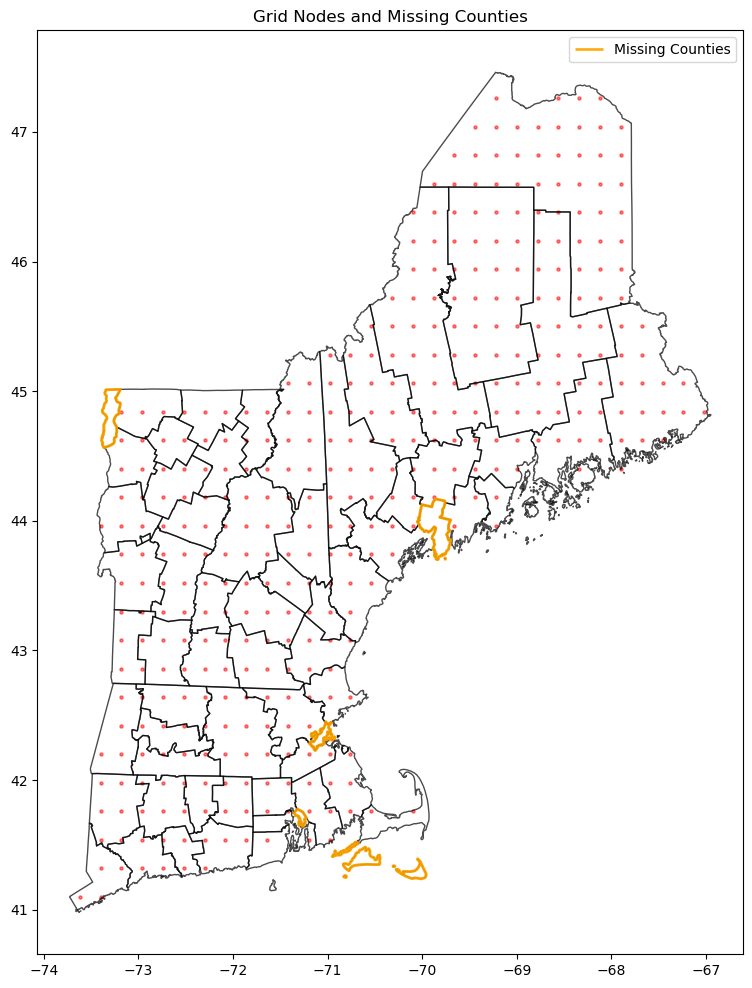

In [180]:
# ...existing code...

fig, ax = plt.subplots(figsize=(10, 12))
counties.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)
nodes_gdf.plot(
    ax=ax,
    color="red",
    markersize=5,
    alpha=0.5,
)

# Highlight missing counties
if missing:
    missing_gdf = counties[counties["county_id"].isin(missing)]
    missing_gdf.boundary.plot(
        ax=ax,
        edgecolor="orange",
        linewidth=2,
        alpha=0.9,
        label="Missing Counties"
    )
    # Optionally fill them for more visibility
    missing_gdf.plot(
        ax=ax,
        color="none",
        edgecolor="orange",
        linewidth=2,
        alpha=0.5
    )

plt.legend()
plt.title("Grid Nodes and Missing Counties")
plt.savefig("grid_nodes_and_missing_counties.png", dpi=300)
plt.show()
# ...existing code...

In [ ]:

# IDs in demand_df.columns but not in counties["county_id"]
diff1 = np.setdiff1d(
    np.sort(np.array(demand_df.columns).astype(int)),
    np.sort(counties["county_id"].astype(int).values)
)
print("In demand_df.columns but not in counties:", diff1)

# IDs in counties["county_id"] but not in demand_df.columns
diff2 = np.setdiff1d(
    np.sort(counties["county_id"].astype(int).values),
    np.sort(np.array(demand_df.columns).astype(int))
)
print("In counties but not in demand_df.columns:", diff2)

In demand_df.columns but not in counties: []
In counties but not in demand_df.columns: []


In [ ]:
# 4) Handle counties with no nodes inside
# 4a) find which counties are “missing”
present = set(nodes_gdf["county_id"].dropna().unique())
all_ctys = set(counties["county_id"])
missing = list(all_ctys - present)

if missing:
    # prepare a KD‑tree of your 400 nodes
    grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
    nbr = NearestNeighbors(n_neighbors=1).fit(grid_coords)
    # for each missing county, assign its centroid’s nearest node
    for cty in missing:
        centroid = counties.loc[counties["county_id"]==cty, "geometry"].iloc[0].centroid
        _, idx = nbr.kneighbors([[centroid.y, centroid.x]])
        nodes_gdf.loc[idx[0], "county_id"] = cty

In [162]:
counties["GEOID"].values

array(['25017', '25005', '25015', '44007', '25025', '09011', '23023',
       '09001', '25023', '25027', '23025', '33017', '50027', '25009',
       '23007', '23003', '25001', '23031', '23021', '44005', '33007',
       '25013', '25021', '23015', '50009', '09007', '09009', '23027',
       '25011', '23017', '33009', '44009', '25007', '50023', '23009',
       '33015', '50025', '23011', '44003', '23029', '25019', '33013',
       '50003', '23005', '50013', '33005', '50019', '50015', '50001',
       '50011', '33001', '44001', '09015', '50005', '33019', '50021',
       '09013', '33003', '25003', '50017', '33011', '09005', '09003',
       '23001', '23013', '23019', '50007'], dtype=object)

In [163]:

# IDs in demand_df.columns but not in counties["county_id"]
diff1 = np.setdiff1d(
    np.sort(np.array(demand_df.columns).astype(int)),
    np.sort(counties["county_id"].astype(int).values)
)
print("In demand_df.columns but not in counties:", diff1)

# IDs in counties["county_id"] but not in demand_df.columns
diff2 = np.setdiff1d(
    np.sort(counties["county_id"].astype(int).values),
    np.sort(np.array(demand_df.columns).astype(int))
)
print("In counties but not in demand_df.columns:", diff2)

In demand_df.columns but not in counties: []
In counties but not in demand_df.columns: []


In [125]:
import geopandas as gpd

county_shp = PROJECT_ROOT / "DATA" / "raw" / "ne_population" / "cb_2022_us_county_500k" / "cb_2022_us_county_500k.shp"
counties_gdf = gpd.read_file(county_shp)

# Filter counties for New England states
ne_abbr = ["CT", "ME", "MA", "NH", "RI", "VT"]
counties_gdf = counties_gdf[counties_gdf["STATEFP"].isin(
    states_gdf[states_gdf["STUSPS"].isin(ne_abbr)]["STATEFP"]
)]

# Reproject if needed
counties_gdf = counties_gdf.to_crs(epsg=4326)

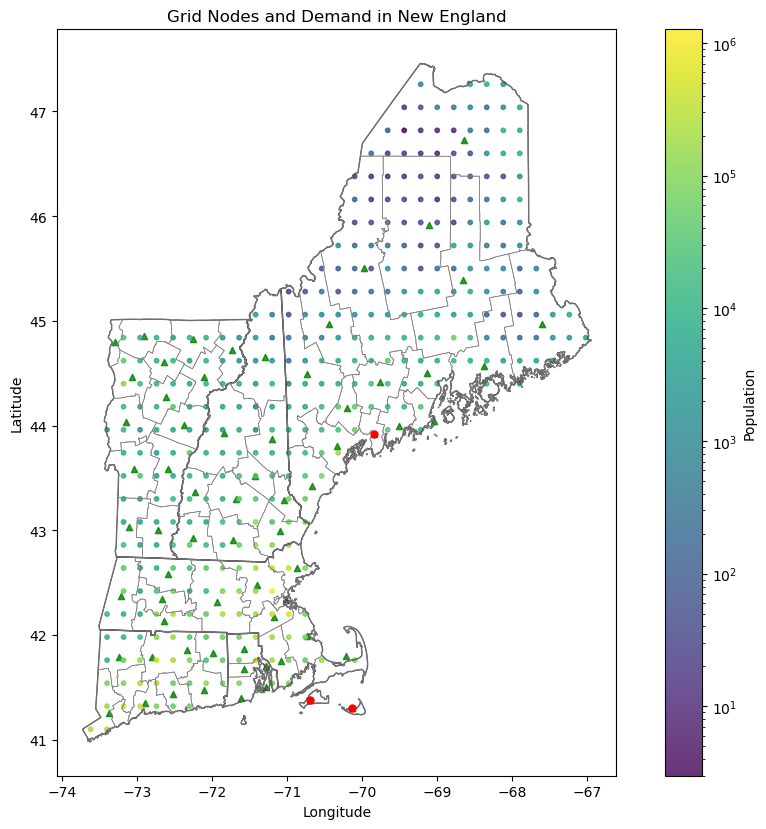

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    demand_points_df["Lon"], 
    demand_points_df["Lat"],
    c='green',
    s=20,           # Increase size for better visibility (optional)
    alpha=0.8,
    marker='^'      # '^' is the marker for triangles
)
ne_states.boundary.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1,
    alpha=0.7,
)
counties_gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5)
plt.plot(missing[:, 1], missing[:, 0], 'ro', markersize=5, label='Missing Points')
scatter_nodes = ax.scatter(
    nodes_df["Lon"], nodes_df["Lat"],
    c=nodes_df["population"],
    cmap="viridis",
    s=10,
    alpha=0.8,
    label='Grid Nodes',
    norm=LogNorm()  # Use log scale for color
)
plt.colorbar(scatter_nodes, ax=ax, label="Population")
plt.tight_layout()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid Nodes and Demand in New England")
# plt.savefig("grid_nodes_and_demand_in_new_england.png", dpi=300)
plt.show()

In [77]:
missing = demand_points_df.iloc[[8, 9, 26]].values

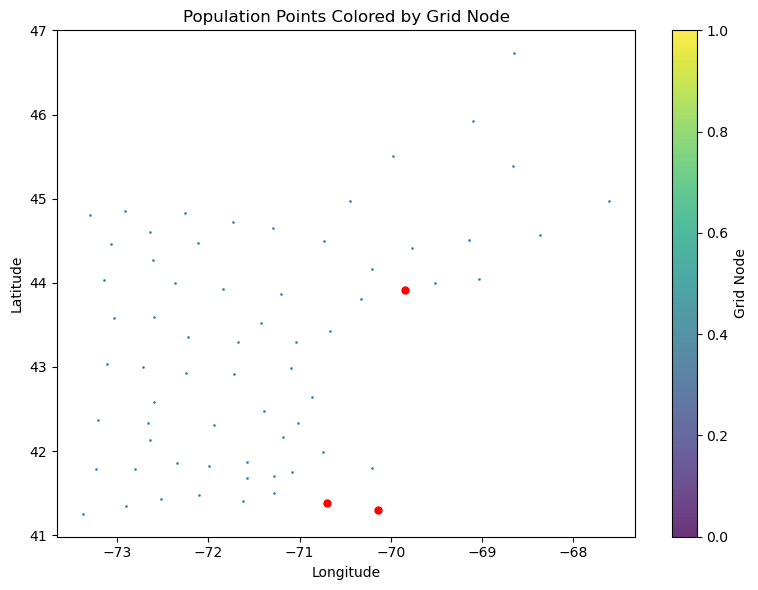

In [78]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    demand_points_df["Lon"], 
    demand_points_df["Lat"],
    s=1,           # smaller dots
    alpha=0.8
)

plt.plot(missing[:, 1], missing[:, 0], 'ro', markersize=5, label='Missing Points')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Population Points Colored by Grid Node")
plt.colorbar(scatter, label="Grid Node")
plt.tight_layout()
plt.savefig("population_points_colored_by_grid_node.png", dpi=300)
plt.show()

In [52]:
# Step 2: Assign grid nodes to original demand nodes
demand_coords = demand_points_df.values

nbrs_demand = NearestNeighbors(n_neighbors=1).fit(demand_coords)
_, original_indices = nbrs_demand.kneighbors(grid_coords)

nodes_df['original_node'] = original_indices.flatten()



In [58]:
# Step 3: Calculate weights for each original node
weights = []
for idx in range(len(demand_points_df)):
    mask = nodes_df['original_node'] == idx
    total_pop = nodes_df.loc[mask, 'population'].sum()
    if total_pop == 0:
        weights.append(pd.Series(0, index=nodes_df.index[mask]))
    else:
        weights.append(nodes_df.loc[mask, 'population'] / total_pop)

# Create a weight matrix
weight_matrix = pd.DataFrame(0.0, index=nodes_df.index, columns=demand_df.columns)
for idx, col in enumerate(demand_df.columns):
    mask = nodes_df['original_node'] == idx
    weight_matrix.loc[mask, col] = weights[idx]



In [132]:
final_demand, enriched_nodes = disaggregate_demand(
    counties_gdf,
    demand_df, 
    demand_points_df,
    nodes_df,
    population_df
)

IndexError: single positional indexer is out-of-bounds

In [71]:
# Step 4: Disaggregate demand to grid nodes
grid_demand = demand_df.values @ weight_matrix.T.values
grid_demand_df = pd.DataFrame(grid_demand, index=demand_df.index, columns=nodes_df.index)

# Verify conservation of demand
assert np.allclose(grid_demand_df.sum(axis=1), demand_df.sum(axis=1))

AssertionError: 

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


def load_data(config: Config) -> tuple[xr.DataArray, xr.DataArray, pd.DataFrame, pd.DataFrame]:
    """
    Load and preprocess wind, solar, and demand data.

    Returns:
        wind (xr.DataArray): Stacked and cleaned wind capacity factors.
        solar (xr.DataArray): Stacked and cleaned solar capacity factors.
        df_demand (pd.DataFrame): Demand time series (in MW).
        df_demand_lat_lon (pd.DataFrame): Demand location coordinates.
    """
    wind = xr.open_dataset(config.path.wind_cf_file)['cf']
    solar = xr.open_dataset(config.path.solar_cf_file)['cf']
    wind = wind.stack(z=("lat", "lon")).dropna('z', how='all')
    solar = solar.stack(z=("lat", "lon")).dropna('z', how='all')

    demand_df = pd.read_csv(config.path.demand_file).iloc[:, 1:] * 1000  # Convert from GW to MW
    # demand_lat_lon_df = pd.read_csv(config.path.demand_lat_lon_file)[['Lat', 'Lon']]
    # demand_lat_lon_df['Lon'] = -demand_lat_lon_df['Lon']

    population_df = pd.read_csv(config.path.population_file)
    population_df = population_df.rename(columns={"longitude": "Lon", "latitude": "Lat"})

    return wind, solar, demand_df, population_df

def get_counties(config: Config) -> gpd.GeoDataFrame:
    """ 
    Load and filter New England counties from shapefile.
    Returns:
        counties (gpd.GeoDataFrame): Filtered counties with geometry and FIPS codes.
    """
    # 2) Read New England county polygons
    COUNTY_SHP =  config.path.county_file
    counties = gpd.read_file(COUNTY_SHP).to_crs(epsg=4326)
    ne_fips = ["09","23","25","33","44","50"]  # CT, ME, MA, NH, RI, VT
    counties = counties[counties["STATEFP"].isin(ne_fips)]
    counties["county_id"] = counties["GEOID"]  # e.g. "25027"
    return counties


class FineNetwork():
    def __init__(self, config: Config):     
        self.config = config
        self.wind, self.solar, self.demand_df, self.population_df = load_data(config)
        self.counties = get_counties(config)

    def _process_capacity_factors(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Process capacity factors for wind and solar"""
        wind = self.wind
        solar = self.solar
        wind_points = np.column_stack((wind.lat.values, wind.lon.values))
        wind_values = wind.values.astype(np.float64)
        solar_points = np.column_stack((solar.lat.values, solar.lon.values))
        solar_values = solar.values.astype(np.float64)

        wind_values = np.delete(wind_values, 181, axis=1) # Remove the 181st column for wind data
        wind_points = np.delete(wind_points, 181, axis=0)  # Remove the 181st row for wind data

        wind_df = pd.DataFrame(wind_values, columns=range(wind_values.shape[1]))
        solar_df = pd.DataFrame(solar_values, columns=range(solar_values.shape[1]))

        if not np.array_equal(wind_points, solar_points):
            raise ValueError("Wind and solar points do not match!")
        
        nodes_df = pd.DataFrame(wind_points, columns=["Lat", "Lon"])
            
        return nodes_df, wind_df, solar_df
    
    def _process_demand(self, nodes_df) -> pd.DataFrame:
        """Process demand data and disaggregate it to grid nodes"""
        demand_df = self.demand_df
        population_df = self.population_df
        counties = self.counties

        # 3) Attach each population hexagon to a county
        pop_gdf = gpd.GeoDataFrame(
            population_df,
            geometry=gpd.points_from_xy(population_df.Lon, population_df.Lat),
            crs="EPSG:4326"
        )
        # spatial join on “within”
        pop_gdf = gpd.sjoin(pop_gdf, counties[["county_id","geometry"]],
                            how="left", predicate="within")

        # for any population point that fell outside (NaN county_id), snap to the nearest county
        missing_pt = pop_gdf["county_id"].isna()
        if missing_pt.any():
            # build centroids and kd‑tree of county centroids
            cents = np.vstack([
                counties.geometry.centroid.y,
                counties.geometry.centroid.x
            ]).T
            nbr = NearestNeighbors(n_neighbors=1).fit(cents)
            pts = np.vstack([pop_gdf.loc[missing_pt,"Lat"], pop_gdf.loc[missing_pt,"Lon"]]).T
            _, idx = nbr.kneighbors(pts)
            pop_gdf.loc[missing_pt,"county_id"] = counties.iloc[idx.flatten()]["county_id"].values

        # 4) Snap each population point to its nearest grid node
        grid_coords = np.vstack([nodes_df.Lat, nodes_df.Lon]).T
        nbr_nodes = NearestNeighbors(n_neighbors=1).fit(grid_coords)
        pop_pts = np.vstack([pop_gdf.Lat, pop_gdf.Lon]).T
        _, node_idx = nbr_nodes.kneighbors(pop_pts)
        pop_gdf["node_id"] = node_idx.flatten()

        # 5) Compute population per (county_id, node_id)
        pop_cn = (
            pop_gdf
            .groupby(["county_id","node_id"])["population"]
            .sum()
            .unstack(fill_value=0)   # rows=county_id, cols=node_id
        )

        # 6) Build weight matrix W where each row sums to 1
        W = pop_cn.div(pop_cn.sum(axis=1), axis=0).fillna(0)
        #    — if a county had zero total pop (unlikely), its row becomes all zeros

        # 7) Reorder demand_df to match W’s rows, then disaggregate
        demand_df.columns = demand_df.columns.map(lambda x: str(x).zfill(5)) # Ensure demand_df columns are zero-padded to 5 digits (FIPS codes)
        demand_df = demand_df.loc[:, W.index]    # ensure same county order
        grid_demand = demand_df.values.dot(W.values)
        grid_demand_df = pd.DataFrame(
            grid_demand,
            index=demand_df.index,
            columns=W.columns
        )

        if not np.allclose(grid_demand_df.sum(axis=1),demand_df.sum(axis=1),atol=1e-6):
            raise ValueError("Demand conservation check failed!")
        
        return grid_demand_df

    def build_fine_ntw(self) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """ 
        Process the data and return a dictionary of DataFrames.
        """
        nodes_df, wind_df, solar_df = self._process_capacity_factors()
        grid_demand_df = self._process_demand(nodes_df)
        return {
            'nodes': nodes_df,
            'time_series':{
                'wind': wind_df,
                'solar': solar_df,
                'demand': grid_demand_df
                }
            }
    

In [ ]:
Fine_NTW = FineNetwork(config)
fine_ntw = Fine_NTW.build_fine_ntw()

C:\Users\g630d\AppData\Local\Temp\ipykernel_5320\1116297311.py:96: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.y,
C:\Users\g630d\AppData\Local\Temp\ipykernel_5320\1116297311.py:97: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.geometry.centroid.x


In [218]:
pd.read_csv(config.path.coarse_node_file)

,node_num,State,Lat,Lon,Offshore_wind_allowed,ISONE_zone
0,0.0,MA,42.642711,70.865107,1.0,MA
1,1.0,MA,42.479477,71.396507,1.0,MA
2,2.0,MA,42.331960,71.020173,1.0,MA
3,3.0,MA,42.169703,71.179875,1.0,MA
4,4.0,MA,41.644282,70.576707,1.0,MA
5,5.0,MA,42.311693,71.940282,0.0,MA
6,6.0,MA,42.358691,72.776236,0.0,MA
7,7.0,ME,44.958418,69.250412,0.0,ME
8,8.0,ME,43.829991,70.263051,0.0,ME
9,9.0,VT,44.161374,72.685273,0.0,VT


In [226]:
coarse_nodes_df = pd.read_csv(config.path.coarse_node_file)[['Lat', 'Lon']]
coarse_nodes_df['Lon'] = -coarse_nodes_df['Lon']

nbr = NearestNeighbors(n_neighbors=1).fit(coarse_nodes_df.values)
_, zones = nbr.kneighbors(fine_ntw['nodes'].values)

In [251]:
from sklearn.metrics import pairwise_distances

class CoarseNetwork():
    def __init__(self, config: Config, fine_network: dict[str, pd.DataFrame | dict[str, pd.DataFrame]]):
        self.config = config
        self.fine_network = fine_network
        
        coarse_nodes_df = pd.read_csv(config.path.coarse_node_file)[['Lat', 'Lon']]
        coarse_nodes_df['Lon'] = -coarse_nodes_df['Lon']
        self.coarse_nodes_df = coarse_nodes_df

        nbr = NearestNeighbors(n_neighbors=1).fit(self.coarse_nodes_df.values)
        _, zones = nbr.kneighbors(self.fine_network['nodes'].values)
        self.fine_to_coarse = zones.flatten() 

    def _aggregate_capacity_factors(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """Aggregate capacity factors for wind and solar by taking the medoid of each zone."""
        wind = self.fine_network['time_series']['wind']
        solar = self.fine_network['time_series']['solar']

        C = len(self.coarse_nodes_df)
        T = wind.shape[0]

        # placeholders
        wind_coarse  = pd.DataFrame(index=wind.index,  columns=range(C), dtype=float)
        solar_coarse = pd.DataFrame(index=solar.index, columns=range(C), dtype=float)

        for zone in range(C):
            # fine nodes assigned to this zone
            mask = (self.fine_to_coarse == zone)
            idxs = np.where(mask)[0]

            if len(idxs) == 0:
                raise ValueError(f"Zone {zone} has no fine nodes assigned!")

            # slice out the sub‑matrices
            wsub = wind.iloc[:, idxs]
            ssub = solar.iloc[:, idxs]

            # compute pairwise distances and pick medoid
            Dw = pairwise_distances(wsub.T)      # k×k
            medoid_w = idxs[ Dw.sum(axis=0).argmin() ]
            Ds = pairwise_distances(ssub.T)
            medoid_s = idxs[ Ds.sum(axis=0).argmin() ]

            # assign the medoid time series
            wind_coarse.iloc[:, zone]  = wind.iloc[:, medoid_w].values
            solar_coarse.iloc[:, zone] = solar.iloc[:, medoid_s].values

        return wind_coarse, solar_coarse

    def _aggregate_demand(self) -> pd.DataFrame:
        """
        Aggregate demand by summing over fine nodes assigned to each coarse node.
        """
        grid_demand_df = self.fine_network['time_series']['demand']

        C = len(self.coarse_nodes_df)

        demand_coarse = pd.DataFrame(
            index=grid_demand_df.index,
            columns=range(C),
            dtype=float
        )

        for zone in range(C):
            # fine nodes assigned to this zone
            mask = (self.fine_to_coarse == zone)
            idxs = np.where(mask)[0]

            if len(idxs) == 0:
                raise ValueError(f"Zone {zone} has no fine nodes assigned!")
            
            # sum demand of all fine nodes in this zone
            demand_coarse.iloc[:, zone] = grid_demand_df.iloc[:, idxs].sum(axis=1).values

        if not np.allclose(
            demand_coarse.sum(axis=1),
            grid_demand_df.sum(axis=1),
            atol=1e-6
        ):
            raise ValueError("Demand conservation check failed!")

        return demand_coarse

    def build_coarse_ntw(self) -> dict[str, pd.DataFrame | dict[str, pd.DataFrame]]:
        """
        Build the coarse network by aggregating capacity factors and demand.
        """
        wind_df, solar_df = self._aggregate_capacity_factors()
        demand_df = self._aggregate_demand()
        return {
            'nodes': self.coarse_nodes_df,
            'time_series':{
                'wind': wind_df,
                'solar': solar_df,
                'demand': demand_df
                }
            }

In [252]:
Coarse_NTW = CoarseNetwork(config, fine_ntw)
coarse_ntw = Coarse_NTW.build_coarse_ntw()

In [ ]:
coarse_ntw['time_series']['wind']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,801.635349,1055.657308,2459.595511,1325.255982,615.386312,748.047439,706.494261,599.425060,785.724021,527.538858,834.305093,391.151665,804.067778,918.261997,1146.513053,945.826936,522.972260
1,754.624510,993.749689,2315.355803,1247.538107,579.297800,704.179192,665.062844,564.272574,739.646280,496.602043,785.378380,368.213095,756.914292,864.411744,1079.277320,890.360173,492.303247
2,730.436256,961.896670,2241.140863,1207.550316,560.729358,681.607881,643.745344,546.185741,715.938130,480.684277,760.204362,356.410627,732.652644,836.704440,1044.682852,861.821135,476.523272
3,719.606402,947.635055,2207.912463,1189.646503,552.415672,671.501983,634.200817,538.087687,705.323233,473.557385,748.933150,351.126285,721.789928,824.298995,1029.193803,849.043296,469.458073
4,710.555287,935.715825,2180.141629,1174.683286,545.467460,663.055919,626.223923,531.319691,696.451770,467.601042,739.513167,346.709865,712.711349,813.931070,1016.248739,838.364141,463.553291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1109.601524,1461.211708,3404.504218,1834.382752,851.800748,1035.426618,977.909856,829.707623,1087.577502,730.204726,1154.822082,541.421338,1112.968425,1271.032912,1586.971723,1309.187539,723.883767
8756,1112.608788,1465.171914,3413.731175,1839.354333,854.109316,1038.232853,980.560207,831.956314,1090.525077,732.183742,1157.951904,542.888709,1115.984814,1274.477691,1591.272766,1312.735726,725.845652
8757,1097.182182,1444.856929,3366.398916,1813.851213,842.266870,1023.837488,966.964488,820.421026,1075.404667,722.031826,1141.896604,535.361418,1100.511398,1256.806730,1569.209361,1294.534308,715.781615
8758,1070.439559,1409.640113,3284.346604,1769.640563,821.737532,998.882563,943.395780,800.424156,1049.192848,704.433086,1114.064116,522.312565,1073.687630,1226.173433,1530.961589,1262.981442,698.335217


In [14]:
processor = DataProcessor(config)

Converted susceptance of 5276 transmission lines. Skipped 429 transformers.


In [37]:
data = processor.processed_data

In [16]:
data['nodes']

,bus_id,Lat,Lon
0,0,41.10,-73.62
1,1,41.10,-73.40
2,2,41.32,-73.40
3,3,41.32,-73.18
4,4,41.32,-72.96
...,...,...,...
380,380,47.04,-67.90
381,381,47.26,-69.22
382,382,47.26,-68.56
383,383,47.26,-68.34


In [38]:
data["time_series"]["demand"]

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,384
0,0.025812,1.202917,65.576928,1.296391,78.666941,4.847077,56.442781,1.086472,0.007907,0.015230,...,0.000034,0.000730,0.000978,0.000071,8.104157e-07,3.590061e-09,2.525409e-10,6.135512e-08,1.194751e-08,5.182943e-10
1,0.024299,1.132373,61.731256,1.220366,74.053622,4.562827,53.132769,1.022757,0.007444,0.014337,...,0.000032,0.000688,0.000921,0.000067,7.628899e-07,3.379527e-09,2.377309e-10,5.775703e-08,1.124686e-08,4.878996e-10
2,0.023520,1.096077,59.752562,1.181249,71.679955,4.416573,51.429686,0.989974,0.007205,0.013877,...,0.000031,0.000666,0.000891,0.000065,7.384367e-07,3.271202e-09,2.301109e-10,5.590572e-08,1.088636e-08,4.722608e-10
3,0.023171,1.079826,58.866637,1.163736,70.617188,4.351090,50.667160,0.975296,0.007098,0.013672,...,0.000031,0.000656,0.000878,0.000064,7.274883e-07,3.222701e-09,2.266991e-10,5.507683e-08,1.072495e-08,4.652588e-10
4,0.022880,1.066244,58.126220,1.149098,69.728974,4.296363,50.029876,0.963029,0.007009,0.013500,...,0.000030,0.000647,0.000867,0.000063,7.183380e-07,3.182166e-09,2.238477e-10,5.438408e-08,1.059006e-08,4.594068e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.035729,1.665044,90.769773,1.794429,108.888608,6.709190,78.126540,1.503864,0.010945,0.021081,...,0.000048,0.001011,0.001354,0.000099,1.121755e-06,4.969264e-09,3.495601e-10,8.492606e-08,1.653741e-08,7.174087e-10
8756,0.035825,1.669557,91.015780,1.799293,109.183720,6.727373,78.338280,1.507940,0.010975,0.021138,...,0.000048,0.001014,0.001358,0.000099,1.124795e-06,4.982732e-09,3.505075e-10,8.515623e-08,1.658223e-08,7.193530e-10
8757,0.035329,1.646408,89.753822,1.774345,107.669860,6.634097,77.252100,1.487032,0.010823,0.020845,...,0.000047,0.001000,0.001339,0.000098,1.109200e-06,4.913645e-09,3.456476e-10,8.397552e-08,1.635231e-08,7.093790e-10
8758,0.034468,1.606279,87.566171,1.731097,105.045524,6.472398,75.369164,1.450787,0.010559,0.020337,...,0.000046,0.000975,0.001306,0.000095,1.082164e-06,4.793880e-09,3.372228e-10,8.192871e-08,1.595374e-08,6.920886e-10


In [18]:
ntw = Network(data["nodes"], data["time_series"], config)

In [19]:
spatial = SpatialAggregation(ntw.features, config)

In [20]:
distances = spatial.distance_metrics

Computing distance metrics for 385 nodes. This might take a while...
Computing position distance...
position distance computed in 0:00:00.002173.
Computing duration_curves distance...
duration_curves distance computed in 0:00:01.214388.
Computing time_series distance...
time_series distance computed in 0:00:01.239924.
Computing ramp_duration_curves distance...
ramp_duration_curves distance computed in 0:00:01.403475.
Computing intra_correlation distance...
intra_correlation distance computed in 0:00:00.011420.
Computing inter_correlation distance...
inter_correlation distance computed in 0:00:59.757878.
All distance metrics computed.
Starting normalization...
Normalization completed in 0:00:00.
Total computation time: 0:01:03.629258.
Saving metrics...
Metrics saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\distance_metrics\v11d728cf.


In [21]:
assignment_dict = spatial.aggregate()

In [22]:
temp = TemporalAggregation(config, ntw.features, assignment_dict)

In [23]:
rep_days = temp.aggregate()

In [49]:
weights = [len(cluster_members) for cluster_members in rep_days["clusters"].values()]

In [39]:
results = Results(config, data, assignment_dict, rep_days)

Results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\joint_aggregation_results\v6efb3e6a


In [25]:
visualizer = Visualizer(config, data)

In [40]:
results.results["nodes"]

,bus_id,Lat,Lon
0,52,42.20,-72.30
1,102,43.08,-71.20
2,188,44.40,-71.64
3,250,44.84,-68.78
4,347,46.38,-69.22


In [52]:
def data_cb(model, where):
    if where == gp.GRB.Callback.MIP:
        cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        # Did objective value or best bound change?
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])
            pd.DataFrame(model._data).to_csv('full_solve_log.csv')


def solve_gtep(buses, branches, params, eval_period, weights):
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        GTEP_data = [buses, branches]

        gtep = GTEP(env, GTEP_data, params)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, weights, callback=data_cb)

        return cep_results

        # with open('cep_results_v2.pkl', 'wb') as f:
        #     pickle.dump(cep_results, f)

In [54]:
buses, branches, load, pv, wind, params = read_data(results.results)
eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
    params[key] = params[key] * 1e-5
    
cep_results = solve_gtep(buses, branches, params, eval_period, weights)

PV shape  (240, 5)
Wind shape  (240, 5)
Load shape  (240, 5)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20427 rows, 10845 columns and 56705 nonzeros
Model fingerprint: 0xd1e2d7db
Variable types: 10840 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [2e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 5e+05]
Presolve removed 2420 rows and 2925 columns
Presolve time: 0.06s
Presolved: 18007 rows, 7920 columns, 53760 nonzeros
Variable types: 7915 continuous, 5 integer (0 binary)

Root relaxation: objective 6.525447e+02, 28539 iterations, 1.78 seconds (1.92 work units)

    Nodes    |    Current 

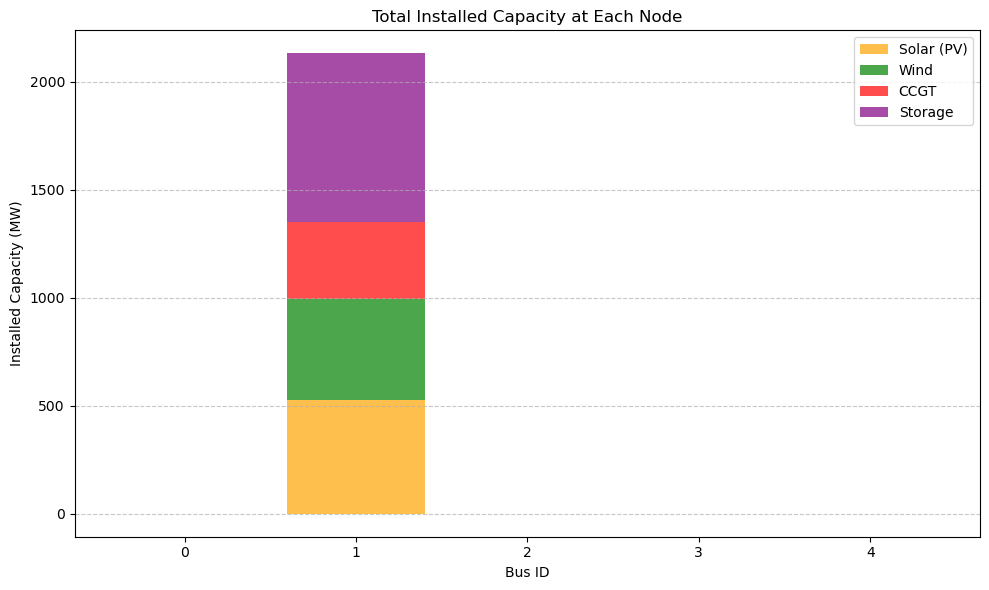

In [57]:
# Extract investments from the loaded results
pv_investment = np.array(list(cep_results["inv"]["PV"].values()))
wind_investment = np.array(list(cep_results["inv"]["Wind"].values()))
ccgt_investment = np.array(list(cep_results["inv"]["CCGT"].values())) * params['CCGT Max Cap']
storage_investment = np.array(list(cep_results["inv"]["Storage Energy"].values()))

# Calculate total capacity installed at each bus
# total_capacity = pv_investment + wind_investment + ccgt_investment + storage_investment

# Create a bar plot
bus_ids = range(len(pv_investment))  # Assuming buses are indexed from 0 to N-1
plt.figure(figsize=(10, 6))
# plt.bar(bus_ids, total_capacity, color='skyblue', label='Total Capacity (MW)')

# Add labels for individual components
plt.bar(bus_ids, pv_investment, color='orange', label='Solar (PV)', alpha=0.7)
plt.bar(bus_ids, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(bus_ids, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(bus_ids, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

# Add plot details
plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(bus_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
visualizer.plot_aggregated_network(results.results)

TypeError: Cannot index by location index with a non-integer key

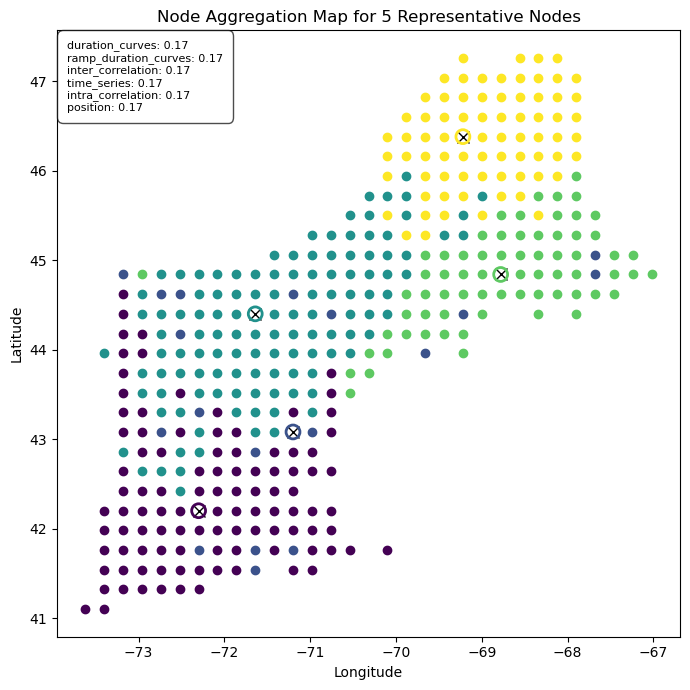

In [ ]:
visualizer.plot_spatial_clusters(assignment_dict);

In [ ]:
visualizer.plot_data(processor)

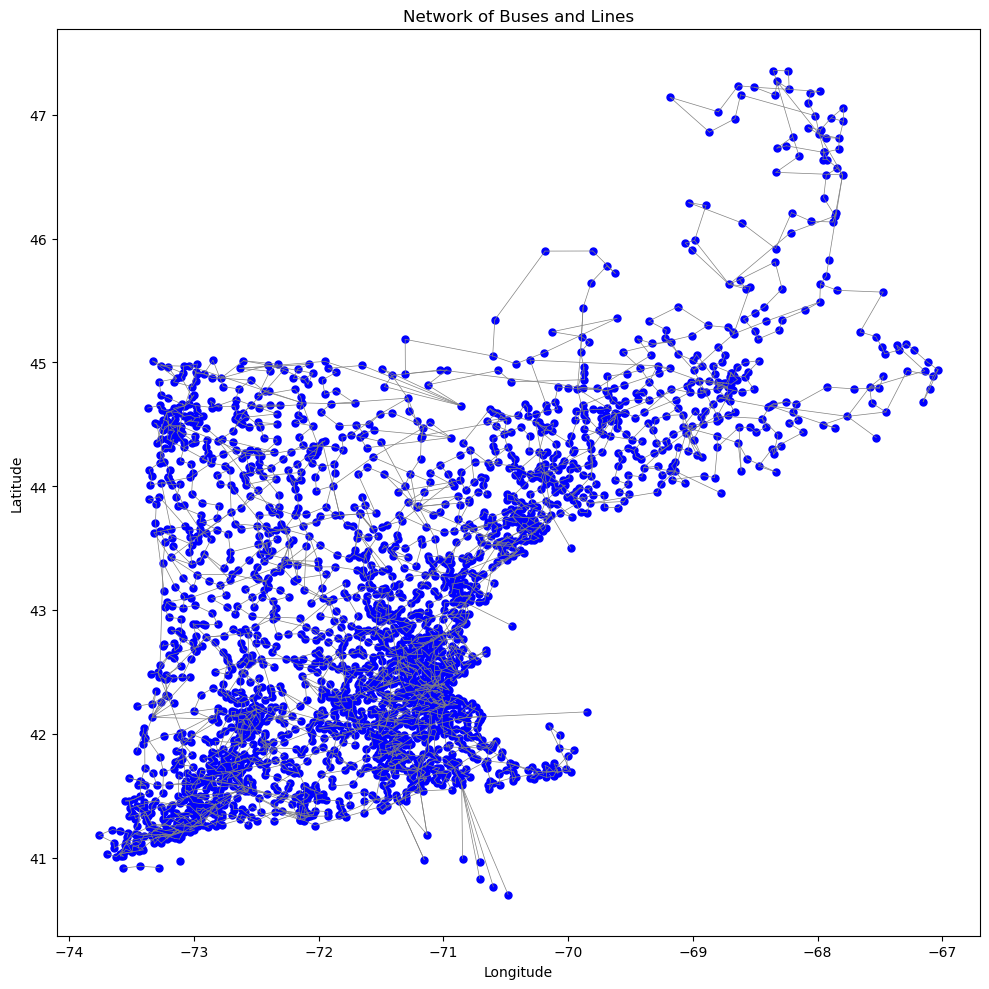

In [ ]:
visualizer.plot_network();